# MNIST classification example with TensorFlow

## Install packages on Google  Cloud Datalab (locally use conda env)
### Select in the Python3 Kernel:
In the menu bar the of 'Kernel', select   
**python3**
### Install needed packages
copy the command below in a Google Cloud Datalab cell  
**!pip install tensorflow==1.12**
### Restart the Kernel 
this is to take into account the new installed packages. Click in the menu bar on:  
**Reset Session**

## Needed librairies

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'1.12.0'

## Import the Data

In [3]:
# get mnist data, split between train and test sets
# on GCP
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# with AXA network
import gzip
import sys
import _pickle as cPickle
def load_data(path):
    f = gzip.open(path, 'rb')
    if sys.version_info < (3,):
        data = cPickle.load(f)
    else:
        data = cPickle.load(f, encoding='bytes')
    f.close()
    return data
(x_train, y_train), (x_test, y_test) = load_data(path='../data/mnist.pkl.gz')

In [4]:
# check data shape (training)
x_train.shape

(60000, 28, 28)

In [5]:
# check data shape (train)
x_test.shape

(10000, 28, 28)

In [6]:
x_train.dtype, x_test.dtype

(dtype('uint8'), dtype('uint8'))

In [7]:
np.max(x_train), np.min(x_train), np.max(x_test), np.min(x_test)  

(255, 0, 255, 0)

## Normalize and reorganize the data

In [8]:
# cast uint8 -> float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [9]:
# renormalize the data 255 grey variation
x_train /= 255
x_test /= 255

In [10]:
# reshape the data 28 x 28 -> 784
x_train = x_train.reshape(len(x_train), x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(len(x_test), x_test.shape[1]*x_test.shape[2])

In [11]:
x_train.shape

(60000, 784)

In [12]:
x_test.shape

(10000, 784)

## Reshape the labels

In [13]:
y_train.shape

(60000,)

In [14]:
y_test.shape

(10000,)

In [15]:
np.unique(y_train), np.unique(y_test)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [16]:
num_classes = len(np.unique(y_train))
num_classes

10

In [17]:
# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [18]:
y_train.shape

(60000, 10)

In [19]:
y_test.shape

(10000, 10)

In [20]:
dim_input=x_train.shape[1]
dim_input

784

## Visualize the data

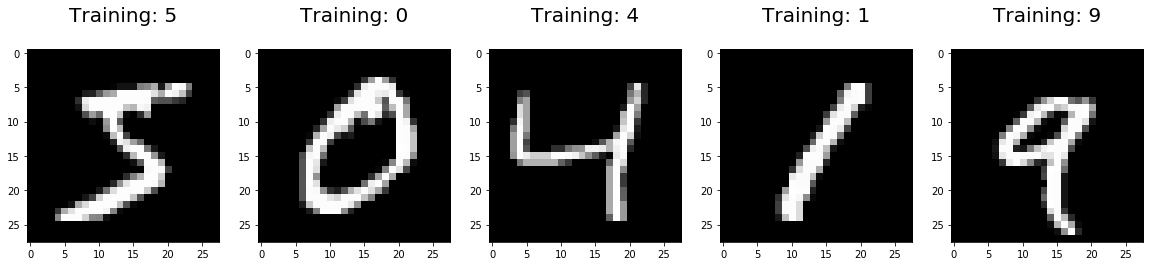

In [21]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(x_train[0:5], y_train[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % np.argmax(label), fontsize = 20)

## Defined some hyperparameters

In [22]:
# number of epoch to train our model
epochs = 10

# print info every n_print
n_print = 1

# size of our mini batch
mini_batch_size = 100

# hidden layer 1
n1=300

In [23]:
# activation function: activation
# X: input features
# n: number neurone for a given layer
def create_layer(X, n, activation):
    ndim = int(X.shape[1])
    stddev = 2.0 / np.sqrt(ndim)
    # He initialization
    initialization = tf.truncated_normal([ndim, n], stddev = stddev)
    #       tf.Variable(tf.random_normal([dim_input, n1], stddev=0.03), name='W1')
    #       tf.Variable(tf.random_normal([n1]), name='b1')
    #       tf.Variable(tf.random_normal([n1, num_classes], stddev=0.03), name='W2')
    #       tf.Variable(tf.random_normal([num_classes]), name='b2')
    W = tf.Variable(initialization)
    b = tf.Variable(tf.zeros([n]))
    Z = tf.matmul(X,W)+b
    return activation(Z), W, b

## Defined our model

In [24]:
# x [60000, 784]
# y [60000, 10]

# 1 layer n1 with 200 neurones
# n1 = 300

#  . . . . . .    input data (ffattened pixels)      x [batch    ,   dim_input]
#   \x/\x/x/      -- fully connected layer (relu)    W1[dim_input,          n1]      B1[n1         ]
#    . . .                                           Y1[batch    ,          n1]
#     \x/         -- fully connected layer (softmax) W2[n1       , num_classes]      B2[num_classes]
#      .                                             Y2[batch    , num_classes]

# reset graph before starting
tf.reset_default_graph()

# tensor (placeholder) for the learning rate
learning_rate = tf.placeholder(tf.float32, shape=())

# tensor (placeholder) for the momentum
momentum = tf.placeholder(tf.float32, shape=())

# tensor (placeholder) for the input data [60000, 784]
x = tf.placeholder(tf.float32, [None, dim_input])

# tensor (placeholder) for the output data [60000, 10]
y = tf.placeholder(tf.float32, [None, num_classes])

# now declare the weights connecting the input to the hidden layer
# calculate the output of the hidden layer
Y1, W1, b1 = create_layer(x, n1, activation = tf.nn.relu)

# output layer
# and the weights connecting the hidden layer to the output layer
y_, W2, b2 = create_layer(Y1, num_classes, activation = tf.nn.softmax)
# intermediate computation needed for tf.nn.softmax_cross_entropy_with_logits
Ylogits= tf.matmul(Y1, W2) + b2

# now let's define the cost function which we are going to train the model on

# built-in cross entropy
# WARNING: This op expects unscaled logits, since it performs a softmax on logits internally for efficiency. 
# Do not call this op with the output of softmax, as it will produce incorrect results.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=Ylogits)
cost = tf.reduce_mean(cross_entropy)

# add optimisers
optimizerGD = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
optimizerAdam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
optimizerMomentum = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=momentum).minimize(cost)
optimizerRMSP = tf.train.RMSPropOptimizer(learning_rate=learning_rate, momentum=momentum).minimize(cost)

# finally setup the initialisation operator
init= tf.global_variables_initializer()

# define an accuracy assessment operation
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [25]:
def run_logistic_model(learning_r, 
                       momentum_r,
                       training_epochs, 
                       train_obs, 
                       train_labels, 
                       test_obs, 
                       test_labels, 
                       optString = 'GD',
                       n_print=10,
                       debug = False,
                      ):
    sess = tf.Session()
    sess.run(init)
    
    dispatcher = {'GD': optimizerGD, 
                  'Adam': optimizerAdam,
                  'Momentum': optimizerMomentum, 
                  'RMSP': optimizerRMSP}
    try:
        opt = dispatcher[optString]
    except KeyError:
        raise ValueError('Invalid optimizer')
    
    cost_history_train = np.empty(shape=[0], dtype = float)
    cost_history_test = np.empty(shape=[0], dtype = float)
    
    for epoch in range(training_epochs+1):
        for i in range(0, train_obs.shape[0], mini_batch_size):
            x_train_batch = train_obs[i:i + mini_batch_size,:]
            y_train_batch = train_labels[i:i + mini_batch_size]
            
            feed_dict_train = {x: x_train_batch, y: y_train_batch, learning_rate: learning_r, momentum: momentum_r}
            sess.run(opt, feed_dict = feed_dict_train)
        
        #cost_ = sess.run(cost, feed_dict=feed_dict_train)
        #cost_history = np.append(cost_history, cost_)
        
        cost_train = sess.run(cost, feed_dict={x: train_obs, y: train_labels})
        cost_history_train = np.append(cost_history_train, cost_train)
        
        cost_test = sess.run(cost, feed_dict={x: test_obs, y: test_labels})
        cost_history_test = np.append(cost_history_test, cost_test)
        
        if (epoch % n_print == 0) & debug:
            print("Reached epoch",epoch,"cost J =", str.format('{0:.6f}', cost_train))
            acc_train = sess.run(accuracy, feed_dict={x: train_obs, y: train_labels})
            acc_test = sess.run(accuracy, feed_dict={x: test_obs, y: test_labels})
            print(" accurary on the training set", str.format('{0:.2f}', acc_train))
            print(" accurary on the testing set", str.format('{0:.2f}', acc_test))
    return sess, cost_history_train, cost_history_test

In [26]:
sess, cost_history_train, cost_history_test = run_logistic_model(learning_r=0.01,
                                                                 momentum_r=0.9,
                                                                 training_epochs = 100, 
                                                                 train_obs = x_train, 
                                                                 train_labels = y_train, 
                                                                 test_obs = x_test, 
                                                                 test_labels = y_test, 
                                                                 optString = 'Adam',
                                                                 debug = True)

Reached epoch 0 cost J = 0.193346
 accurary on the training set 0.94
 accurary on the testing set 0.94
Reached epoch 10 cost J = 0.047206
 accurary on the training set 0.99
 accurary on the testing set 0.97
Reached epoch 20 cost J = 0.055870
 accurary on the training set 0.99
 accurary on the testing set 0.97
Reached epoch 30 cost J = 0.056901
 accurary on the training set 0.99
 accurary on the testing set 0.97
Reached epoch 40 cost J = 0.033658
 accurary on the training set 0.99
 accurary on the testing set 0.98
Reached epoch 50 cost J = 0.031964
 accurary on the training set 1.00
 accurary on the testing set 0.98
Reached epoch 60 cost J = 0.027605
 accurary on the training set 1.00
 accurary on the testing set 0.97
Reached epoch 70 cost J = 0.039630
 accurary on the training set 1.00
 accurary on the testing set 0.98
Reached epoch 80 cost J = 0.027769
 accurary on the training set 1.00
 accurary on the testing set 0.98
Reached epoch 90 cost J = 0.005634
 accurary on the training set 

In [27]:
print ("Accuracy on training data:", accuracy.eval(feed_dict={x: x_train, y: y_train}, session = sess))
print ("Accuracy on testing data:", accuracy.eval(feed_dict={x: x_test, y: y_test}, session = sess))

Accuracy on training data: 0.99866664
Accuracy on testing data: 0.9782


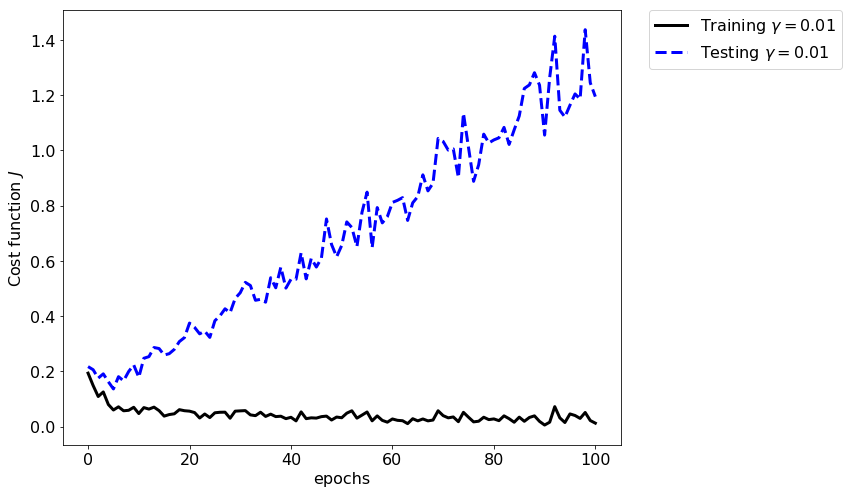

In [28]:
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(cost_history_train, ls='-', color = 'black', lw = 3, label = r'Training $\gamma = 0.01$')
ax.plot(cost_history_test, ls='--', color = 'blue', lw = 3, label = r'Testing $\gamma = 0.01$')
ax.set_xlabel('epochs', fontsize = 16)
ax.set_ylabel('Cost function $J$', fontsize = 16)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 16)
plt.tick_params(labelsize=16);